# Planning & Overview

* `pnl`, `x`, `q`, `o` - PnL, wealth, inventory, offset
* `levels`, `queues` - L5 price levels and queues
* `r`, `rb`, `ra`, `la`, `lb`, `pb`, `pb` - Reservation price, quotes, lambdas, fill probabilities
* `db`, `da`, `db1`, `da1` - Distance from quote to mid, distance from quote to best price level 
* `f` - Number of trades

In [2]:
import pandas as pd
import numpy as np
import math
import random

## Parameter Estimation Helpers

In [5]:
def resample_prices(ms, N):

    levels = pd.read_csv('../data/levels.csv',index_col='time', parse_dates=True)
    levels.index = pd.to_timedelta(levels.index)
    levels['mid'] = (levels['a1'] + levels['b1'])/2
    levels = levels.resample(f'{ms}ms').mean().ffill().div(1000)
    logrets = np.log(levels.mid) - np.log(levels.mid.shift(1))
    sigma = logrets.std() * np.sqrt(N)

    return levels, levels.mid, sigma

clean_levels, s, sigma = resample_prices(100,23400)

In [6]:
clean_levels

,a5,a4,a3,a2,a1,b1,b2,b3,b4,b5,mid
time,,,,,,,,,,,
0 days 00:00:00,2244.000000,2242.500000,2240.000000,2239.900000,2239.500000,2231.800000,2230.700000,2230.400000,2230.000000,2226.200000,2235.650000
0 days 00:00:00.100000,2242.541379,2240.086207,2239.903448,2239.610345,2239.500000,2238.058621,2237.037931,2235.741379,2234.889655,2233.813793,2238.779310
0 days 00:00:00.200000,2242.541379,2240.086207,2239.903448,2239.610345,2239.500000,2238.058621,2237.037931,2235.741379,2234.889655,2233.813793,2238.779310
0 days 00:00:00.300000,2243.462222,2242.395556,2241.962222,2241.320000,2239.882222,2237.500000,2236.500000,2236.155556,2235.777778,2234.977778,2238.691111
0 days 00:00:00.400000,2244.000000,2243.000000,2242.500000,2242.400000,2240.000000,2237.500000,2236.566667,2236.200000,2235.700000,2235.050000,2238.750000
...,...,...,...,...,...,...,...,...,...,...,...
0 days 06:29:59.500000,2206.900000,2206.700000,2206.500000,2206.400000,2206.200000,2205.100000,2205.000000,2204.800000,2204.700000,2204.600000,2205.650000
0 days 06:29:59.600000,2206.900000,2206.700000,2206.500000,2206.400000,2206.200000,2205.100000,2205.000000,2204.800000,2204.700000,2204.600000,2205.650000
0 days 06:29:59.700000,2206.900000,2206.700000,2206.500000,2206.400000,2206.200000,2205.100000,2205.000000,2204.800000,2204.700000,2204.600000,2205.650000


## Simulation Helpers

In [7]:

def create_arrays(N):

    pnl, x, q = np.empty((N)), np.empty((N)), np.empty((N))
    pnl[0], x[0], q[0] = 0, 0, 0
    o, r, ra, rb, rs = np.empty((N)), np.empty((N)), np.empty((N)), np.empty((N)), np.empty((N))
    db, da = np.empty((N)), np.empty((N))
    lb, la = np.empty((N)), np.empty((N))
    pb, pa = np.empty((N)), np.empty((N))
    f = np.empty((N))

    return pnl, x, q, o, r, rb, ra, rs, db, da, lb, la, pb, pa, f



# Simulation

In [8]:



def simulate(ms, gamma, A, k, reduce=False):

    SECONDS_PER_DAY = 60 * 60 * 6.5
    time_step = ms/1e3
    N = int(SECONDS_PER_DAY/time_step)
    T = 1
    dt = 1/N

    clean_levels, s, sigma = resample_prices(ms, N)
    ds = s.diff().fillna(0)
    m = ds.shift(-5).rolling(5).mean().fillna(0)

    
    pnl, x, q, o, r, rb, ra, rs, db, da, lb, la, pb, pa, f  = create_arrays(N)

    for i in range(N-1):

        # Reserve price
        o[i] = - q[i] * gamma * sigma**2 * (T-dt*i) * 1e4
        r[i] = s[i] + o[i] 

        # Reserve spread
        rs[i] = gamma * sigma**2 * (T- dt*i) + 2 / gamma * math.log(1+gamma/k)    

        # optimal quotes
        ra[i] = r[i] + rs[i]/2
        rb[i] = r[i] - rs[i]/2

        # Cap our bid ask
        if ra[i] <= clean_levels.a1[i]:
            ra[i] = clean_levels.a1[i]
        
        if rb[i] >= clean_levels.b1[i]:
            rb[i] = clean_levels.b1[i]

        # Reserve deltas
        da[i] = ra[i] - s[i]
        db[i] = s[i] - rb[i]

        # Intensities
        lb[i] = A * math.exp(-k*db[i])
        la[i] = A * math.exp(-k*da[i])

        # Simulating probability of quotes getting hit/lifted
        yb = random.random()
        ya = random.random()

        pb[i] = (1 - math.exp(-lb[i]*(ms/1e3))) * ((1 - m[i])) 
        pa[i] = (1 - math.exp(-la[i]*(ms/1e3))) * ((1 + m[i]))


        dNa, dNb = 0, 0

        if ya < pa[i]:
            dNa = 1
        if yb < pb[i]:
            dNb = 1
        
        f[i] = dNa + dNb
        q[i+1] = q[i] - dNa + dNb
        x[i+1] = x[i] + ra[i]*dNa - rb[i]*dNb
        pnl[i+1] = x[i+1] + q[i+1]*s[i]

    if reduce:
        return pnl[-1]

    data = {
        's': s,
        'ds': ds,
        'ms': m,
        'q': q,
        'o': o,
        'r': r,
        'rb': rb,
        'ra': ra,
        'rs': rs,
        'db': db,
        'da': da,
        'b2': clean_levels.b2,
        'b1': clean_levels.b1,
        # 'spr': clean_levels.a1 - clean_levels.b1,
        'a1': clean_levels.a1,
        'a2': clean_levels.a2,
        'lb': lb,
        'la': la,
        'pb': pb,
        'pa': pa,
        'pd': pa - pb,
        'pnl': pnl,
        'f': f.cumsum()
    }
    df = pd.DataFrame(data)
    df.set_index(s.index, inplace=True)
    df = df.iloc[:-1,:]

    


    return df

In [52]:
SECONDS_PER_DAY = 60 * 60 * 6.5
time_step = 100/1e3
N = int(SECONDS_PER_DAY/time_step) 
ms = 1e3

A, k = 0.34, 2.13
gamma = 0.1
np.random.seed(42)
df = simulate(ms, gamma, A, k)

In [10]:
df.to_pickle('../data/df.pkl')

<AxesSubplot: title={'center': 'pnl'}, xlabel='time'>

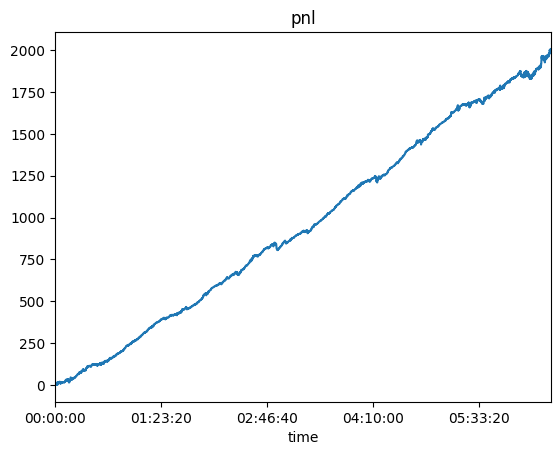

In [12]:
df.pnl.plot(title='pnl')

<AxesSubplot: title={'center': 'inventory'}, xlabel='time'>

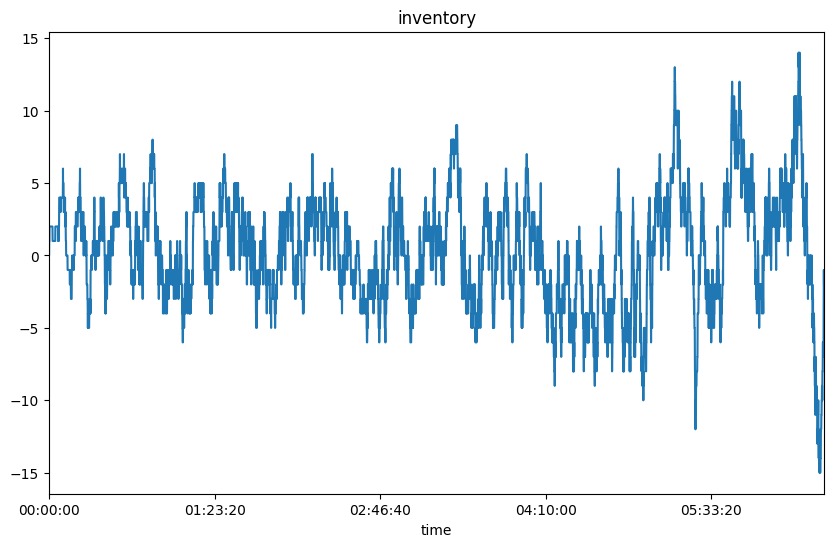

In [53]:
df.q.plot(figsize=(10,6), title='inventory')

In [56]:
sample = df[(df.index > '05:15:00')&(df.index <"05:30:00")]
sample['db1'] = sample.b1 - sample.rb
sample['da1'] = sample.a1 - sample.ra

<AxesSubplot: title={'center': 'offset, db1, da1'}, xlabel='time'>

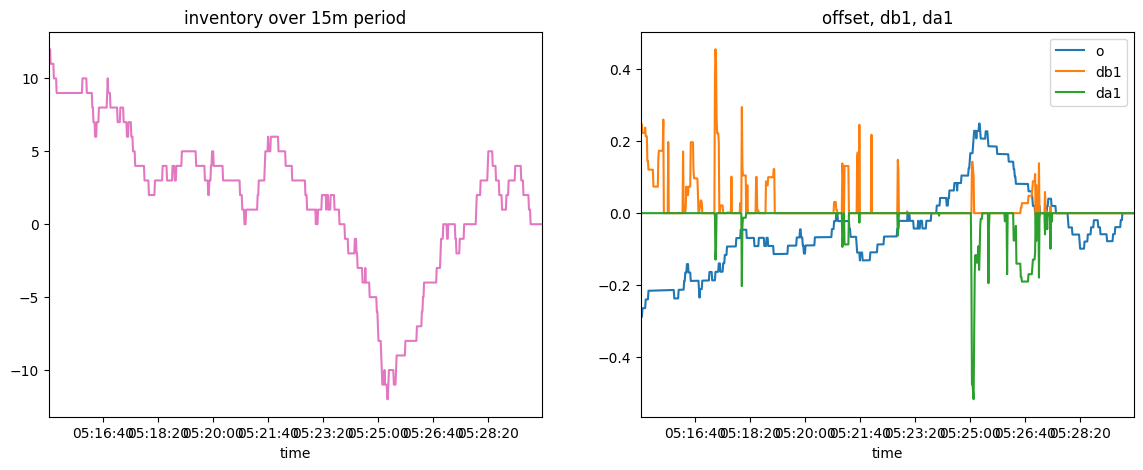

In [80]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(14,5))
sample.q.plot(ax=ax[0], title='inventory', color='tab:pink')
sample[['o', 'db1', 'da1']].plot(title='offset, db1, da1', ax=ax[1])

# Multiple Runs

In [34]:

pnls = []
for sim in range(100):
    pnl = simulate(ms, gamma, A, k, reduce=True)
    pnls.append(pnl)


In [36]:

pnl_df = pd.DataFrame(pnls, columns=['pnl'])

<AxesSubplot: ylabel='Frequency'>

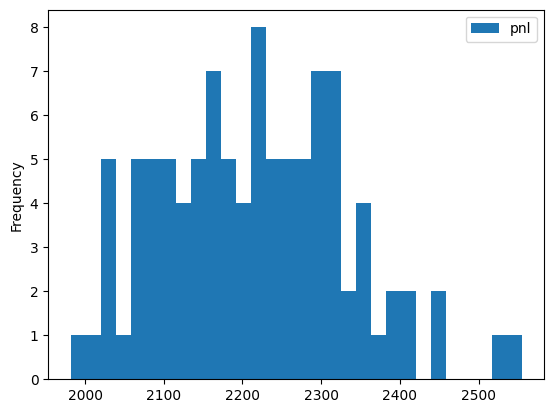

In [44]:
pnl_df.plot(kind='hist',bins=30)

<AxesSubplot: xlabel='time'>

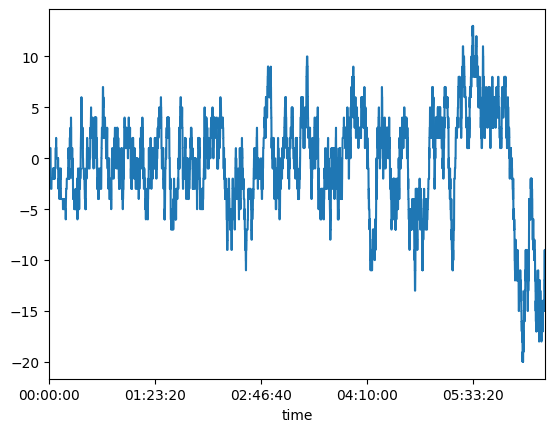

In [48]:
df.q.plot()